In [5]:
"""
Implémentation de LoRA pour Depth Anything V2
Intégration des matrices de faible rang dans le modèle de depth estimation
"""

import torch
import torch.nn as nn
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from peft import LoraConfig, get_peft_model, TaskType
from PIL import Image
import numpy as np

# ============================================================================
# ÉTAPE 1: Charger le modèle pré-entraîné
# ============================================================================

def load_pretrained_model(model_name="depth-anything/Depth-Anything-V2-Small-hf"):
    """
    Charge le modèle Depth Anything V2 pré-entraîné et son processeur d'images
    """
    print(f"📥 Chargement du modèle: {model_name}")
    
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    base_model = AutoModelForDepthEstimation.from_pretrained(model_name)
    
    print(f"✅ Modèle chargé avec succès")
    return base_model, image_processor


# ============================================================================
# ÉTAPE 2: Configuration de LoRA
# ============================================================================

def configure_lora(rank=8, alpha=16, dropout=0.1):
    """
    Configure les paramètres LoRA pour l'adaptation du modèle
    
    Args:
        rank: Rang des matrices de faible rang (r)
        alpha: Facteur de scaling LoRA
        dropout: Taux de dropout pour régularisation
    
    Returns:
        LoraConfig: Configuration LoRA
    """
    print("\n🔧 Configuration de LoRA:")
    print(f"   - Rang (r): {rank}")
    print(f"   - Alpha: {alpha}")
    print(f"   - Dropout: {dropout}")
    
    lora_config = LoraConfig(
        r=rank,  # Rang des matrices de faible rang
        lora_alpha=alpha,  # Facteur de scaling
        target_modules=[
            # Cibler les couches d'attention du Vision Transformer
            "query",
            "value",
            # Optionnel: ajouter "key" et "dense" pour plus de paramètres
        ],
        lora_dropout=dropout,
        bias="none",  # Ne pas adapter les biais
        task_type=TaskType.FEATURE_EXTRACTION,  # Type de tâche
    )
    
    return lora_config


# ============================================================================
# ÉTAPE 3: Intégration de LoRA dans le modèle
# ============================================================================

def integrate_lora_into_model(base_model, lora_config):
    """
    Intègre les matrices LoRA dans le modèle Depth Anything
    et gèle tous les paramètres sauf les matrices de faible rang
    
    Args:
        base_model: Modèle de base pré-entraîné
        lora_config: Configuration LoRA
    
    Returns:
        model: Modèle avec LoRA intégré
    """
    print("\n🔄 Intégration de LoRA dans le modèle...")
    
    # Appliquer LoRA au modèle
    model = get_peft_model(base_model, lora_config)
    
    print("✅ LoRA intégré avec succès")
    
    return model


# ============================================================================
# ÉTAPE 4: Vérification du gel des paramètres
# ============================================================================

def verify_frozen_parameters(model):
    """
    Vérifie que seules les matrices LoRA sont entraînables
    et que tous les autres paramètres sont gelés
    """
    print("\n🔍 Vérification des paramètres:")
    
    trainable_params = 0
    frozen_params = 0
    
    for name, param in model.named_parameters():
        if param.requires_grad:
            trainable_params += param.numel()
        else:
            frozen_params += param.numel()
    
    total_params = trainable_params + frozen_params
    trainable_percent = 100 * trainable_params / total_params
    
    print(f"\n📊 Statistiques des paramètres:")
    print(f"   ✅ Paramètres entraînables (LoRA): {trainable_params:,}")
    print(f"   ❄️  Paramètres gelés (base model): {frozen_params:,}")
    print(f"   📈 Total: {total_params:,}")
    print(f"   💡 Pourcentage entraînable: {trainable_percent:.4f}%")
    
    # Afficher quelques exemples de paramètres LoRA
    print(f"\n🎯 Exemples de paramètres LoRA entraînables:")
    count = 0
    for name, param in model.named_parameters():
        if param.requires_grad and count < 5:
            print(f"   - {name}: {param.shape}")
            count += 1
    
    return trainable_params, frozen_params


# ============================================================================
# ÉTAPE 5: Test d'inférence avec LoRA
# ============================================================================

def test_inference(model, image_processor, image_path):
    """
    Test l'inférence avec le modèle LoRA
    
    Args:
        model: Modèle avec LoRA
        image_processor: Processeur d'images
        image_path: Chemin vers l'image de test
    """
    print("\n🖼️  Test d'inférence...")
    
    # Charger l'image
    image = Image.open(image_path)
    
    # Prétraitement
    inputs = image_processor(images=image, return_tensors="pt")
    
    # Inférence
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth
    
    # Post-traitement
    depth = predicted_depth.squeeze().cpu().numpy()
    
    print(f"✅ Inférence réussie")
    print(f"   - Shape de la carte de profondeur: {depth.shape}")
    print(f"   - Min depth: {depth.min():.4f}")
    print(f"   - Max depth: {depth.max():.4f}")
    
    return depth


# ============================================================================
# FONCTION PRINCIPALE
# ============================================================================

def main():
    """
    Pipeline complet d'implémentation de LoRA pour Depth Anything V2
    """
    print("=" * 70)
    print("🚀 IMPLÉMENTATION DE LoRA POUR DEPTH ANYTHING V2")
    print("=" * 70)
    
    # 1. Charger le modèle pré-entraîné
    base_model, image_processor = load_pretrained_model()
    
    # 2. Configurer LoRA
    lora_config = configure_lora(
        rank=8,        # Rang faible pour réduire les paramètres
        alpha=16,      # Scaling factor
        dropout=0.1    # Régularisation
    )
    
    # 3. Intégrer LoRA dans le modèle
    lora_model = integrate_lora_into_model(base_model, lora_config)
    
    # 4. Vérifier le gel des paramètres
    trainable, frozen = verify_frozen_parameters(lora_model)
    
    # 5. Afficher le résumé du modèle
    print("\n" + "=" * 70)
    print("✅ IMPLÉMENTATION TERMINÉE")
    print("=" * 70)
    print(f"\n📝 Résumé:")
    print(f"   - Modèle: Depth Anything V2 avec LoRA")
    print(f"   - Matrices de faible rang: Intégrées ✅")
    print(f"   - Paramètres base: Gelés ❄️")
    print(f"   - Paramètres LoRA: Entraînables ✅")
    print(f"   - Réduction des paramètres: {100 * trainable / (trainable + frozen):.4f}%")
    
    return lora_model, image_processor


# ============================================================================
# EXEMPLE D'UTILISATION POUR FINE-TUNING
# ============================================================================

def prepare_for_training(lora_model, learning_rate=1e-4):
    """
    Prépare le modèle LoRA pour l'entraînement
    """
    print("\n🎓 Préparation pour le fine-tuning...")
    
    # Créer l'optimiseur uniquement pour les paramètres LoRA
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, lora_model.parameters()),
        lr=learning_rate
    )
    
    print(f"✅ Optimiseur configuré (lr={learning_rate})")
    print(f"   - Seuls les paramètres LoRA seront mis à jour")
    
    return optimizer


if __name__ == "__main__":
    # Exécuter l'implémentation complète
    lora_model, image_processor = main()
    
    # Préparer pour le fine-tuning (optionnel)
    optimizer = prepare_for_training(lora_model)
    
    print("\n💾 Le modèle est prêt pour:")
    print("   1. Fine-tuning sur vos données personnalisées")
    print("   2. Inférence avec les adaptations LoRA")
    print("   3. Sauvegarde des poids LoRA uniquement")
    
    # Exemple: Sauvegarder les poids LoRA
    print("\n💾 Pour sauvegarder les poids LoRA:")
    print('   lora_model.save_pretrained("./depth_lora_checkpoint")')


🚀 IMPLÉMENTATION DE LoRA POUR DEPTH ANYTHING V2
📥 Chargement du modèle: depth-anything/Depth-Anything-V2-Small-hf
✅ Modèle chargé avec succès

🔧 Configuration de LoRA:
   - Rang (r): 8
   - Alpha: 16
   - Dropout: 0.1

🔄 Intégration de LoRA dans le modèle...
✅ LoRA intégré avec succès

🔍 Vérification des paramètres:

📊 Statistiques des paramètres:
   ✅ Paramètres entraînables (LoRA): 147,456
   ❄️  Paramètres gelés (base model): 24,785,089
   📈 Total: 24,932,545
   💡 Pourcentage entraînable: 0.5914%

🎯 Exemples de paramètres LoRA entraînables:
   - base_model.model.backbone.encoder.layer.0.attention.attention.query.lora_A.default.weight: torch.Size([8, 384])
   - base_model.model.backbone.encoder.layer.0.attention.attention.query.lora_B.default.weight: torch.Size([384, 8])
   - base_model.model.backbone.encoder.layer.0.attention.attention.value.lora_A.default.weight: torch.Size([8, 384])
   - base_model.model.backbone.encoder.layer.0.attention.attention.value.lora_B.default.weight: tor

Using device: cuda
📥 Chargement du modèle: depth-anything/Depth-Anything-V2-Small-hf
✅ Modèle chargé avec succès

🖼️  Inférence sur demo01.jpg
✅ Inférence réussie | Shape: (518, 784) | Min: 0.0000 | Max: 10.0071


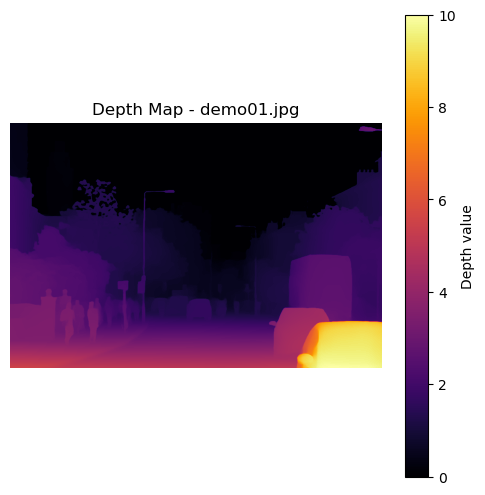


🖼️  Inférence sur demo02.jpg
✅ Inférence réussie | Shape: (518, 784) | Min: 0.0000 | Max: 5.4932


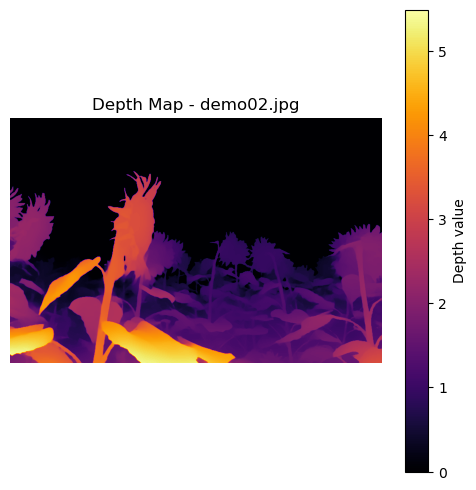


🖼️  Inférence sur demo03.jpg
✅ Inférence réussie | Shape: (518, 798) | Min: 0.2253 | Max: 4.4951


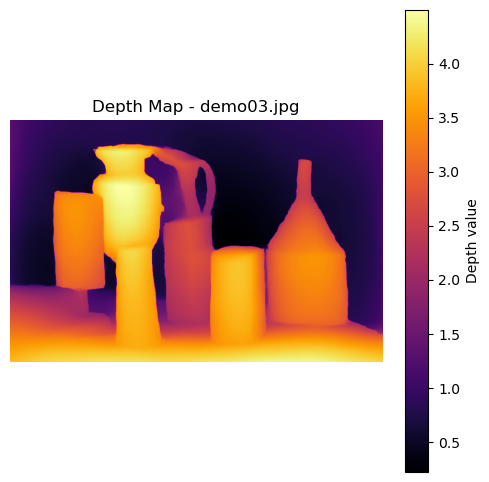


🖼️  Inférence sur demo04.jpg
✅ Inférence réussie | Shape: (518, 798) | Min: 0.0000 | Max: 7.1102


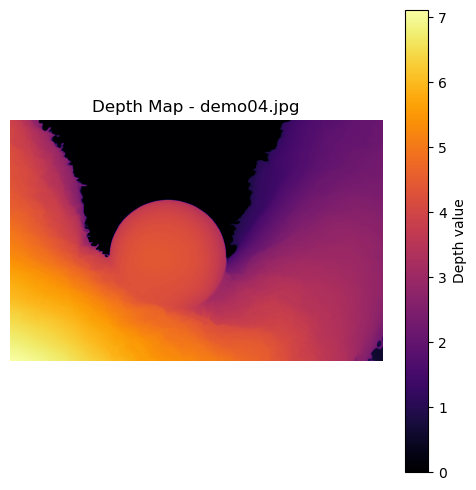


🖼️  Inférence sur demo05.jpg
✅ Inférence réussie | Shape: (518, 798) | Min: 0.6522 | Max: 5.3791


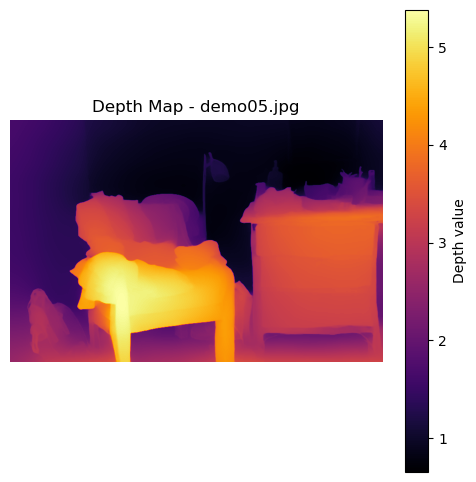


🖼️  Inférence sur demo06.jpg
✅ Inférence réussie | Shape: (518, 784) | Min: 0.0000 | Max: 5.5260


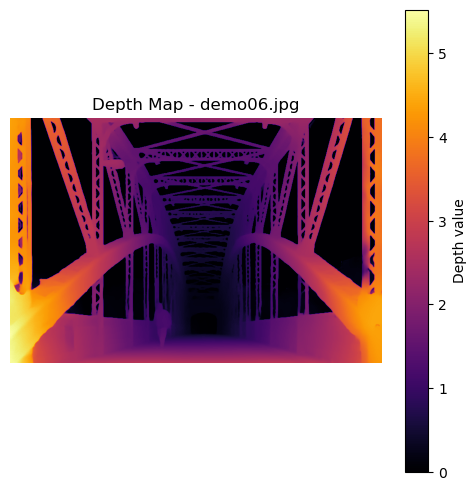


🖼️  Inférence sur demo07.jpg
✅ Inférence réussie | Shape: (518, 784) | Min: 0.0000 | Max: 4.1534


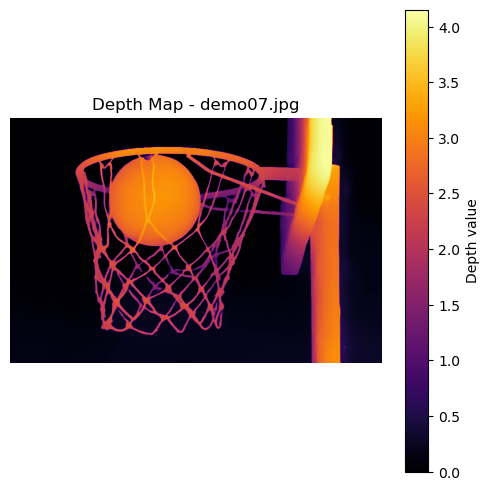


🖼️  Inférence sur demo08.jpg
✅ Inférence réussie | Shape: (350, 518) | Min: 0.0000 | Max: 4.3567


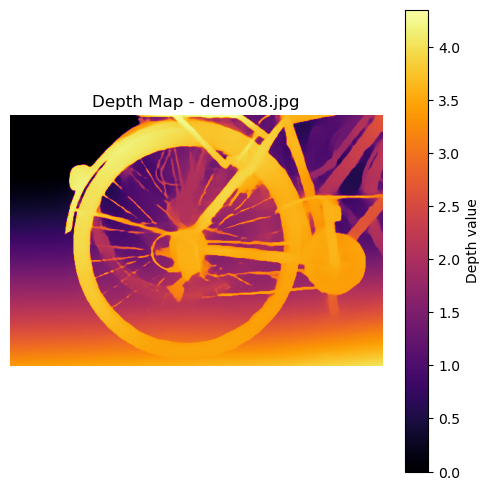


🖼️  Inférence sur demo09.jpg
✅ Inférence réussie | Shape: (518, 784) | Min: 0.0000 | Max: 4.4665


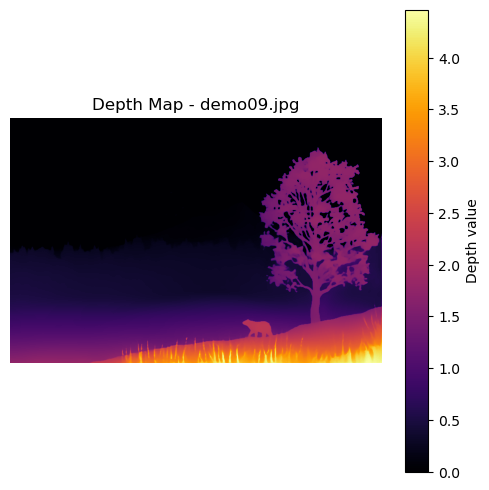


🖼️  Inférence sur demo10.jpg
✅ Inférence réussie | Shape: (518, 798) | Min: 0.0000 | Max: 10.0585


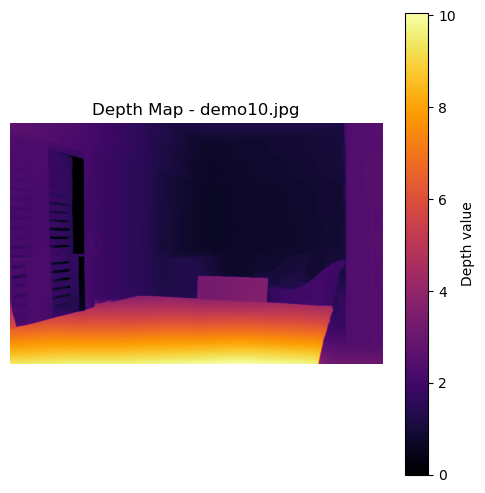


🖼️  Inférence sur demo11.jpg
✅ Inférence réussie | Shape: (518, 798) | Min: 0.0000 | Max: 4.8299


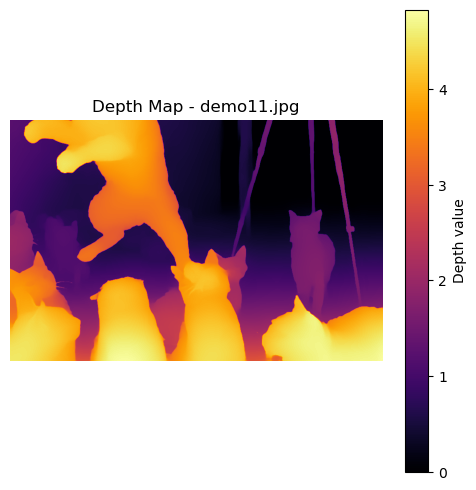


🖼️  Inférence sur demo12.jpg
✅ Inférence réussie | Shape: (518, 798) | Min: 0.0026 | Max: 5.0092


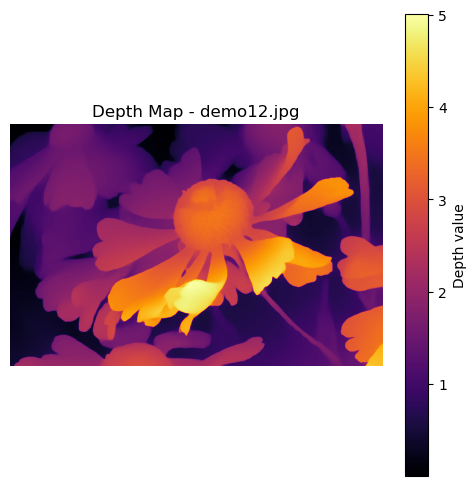


🖼️  Inférence sur demo13.jpg
✅ Inférence réussie | Shape: (518, 798) | Min: 0.5529 | Max: 5.4117


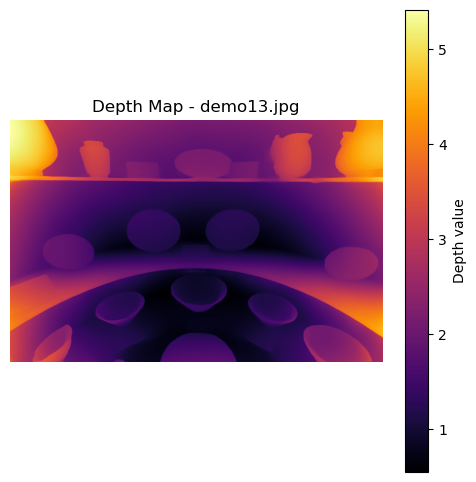


🖼️  Inférence sur demo14.jpg
✅ Inférence réussie | Shape: (518, 798) | Min: 0.0000 | Max: 6.7882


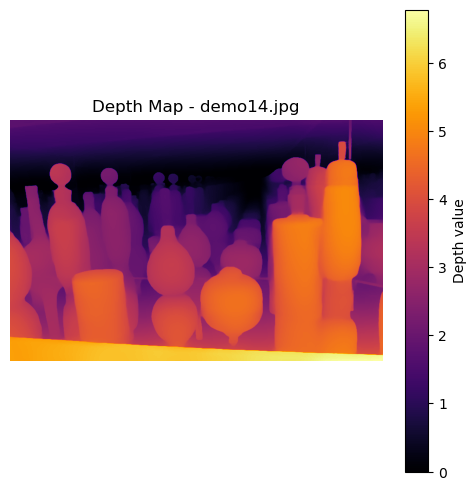


🖼️  Inférence sur demo15.jpg
✅ Inférence réussie | Shape: (518, 784) | Min: 0.1087 | Max: 6.4228


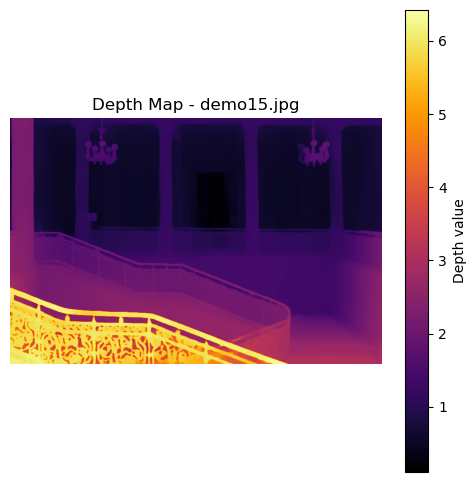


🖼️  Inférence sur demo16.jpg
✅ Inférence réussie | Shape: (518, 798) | Min: 0.0000 | Max: 7.6485


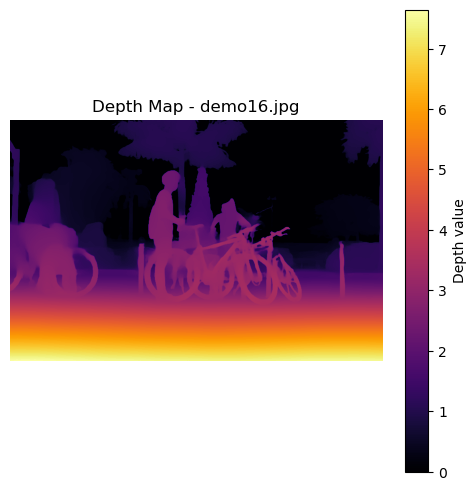


🖼️  Inférence sur demo17.jpg
✅ Inférence réussie | Shape: (518, 798) | Min: 0.4953 | Max: 4.9484


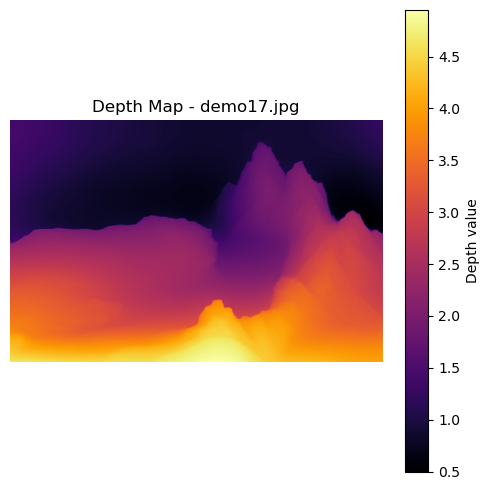


🖼️  Inférence sur demo18.jpg
✅ Inférence réussie | Shape: (518, 798) | Min: 0.9927 | Max: 4.4454


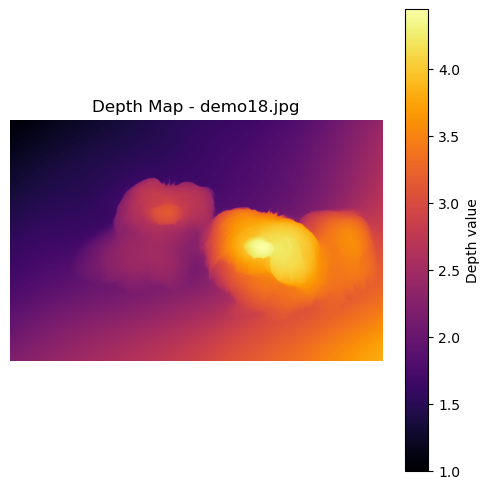


🖼️  Inférence sur demo19.jpg
✅ Inférence réussie | Shape: (518, 798) | Min: 0.0000 | Max: 6.7957


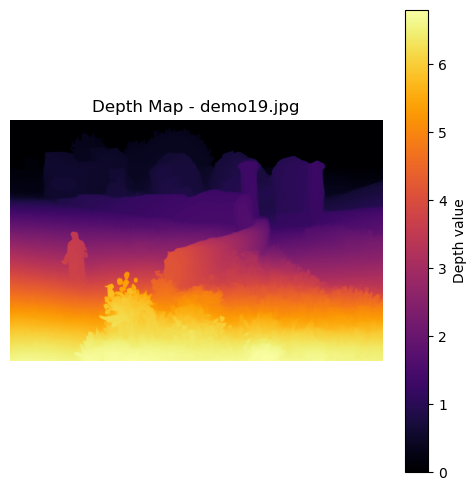


🖼️  Inférence sur demo20.jpg
✅ Inférence réussie | Shape: (518, 798) | Min: 0.2342 | Max: 5.0467


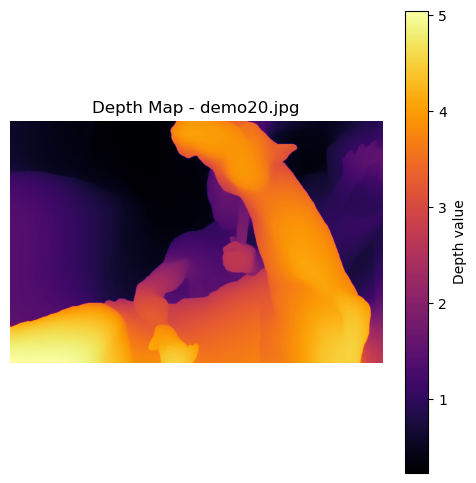

In [6]:
# ============================================================================ 
# IMPORTS
# ============================================================================ 
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from PIL import Image
import matplotlib.pyplot as plt
import os

# ============================================================================ 
# ÉTAPE 1: Charger le modèle pré-entraîné (sans LoRA pour l’inférence)
# ============================================================================ 
def load_pretrained_model(model_name="depth-anything/Depth-Anything-V2-Small-hf"):
    print(f"📥 Chargement du modèle: {model_name}")
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModelForDepthEstimation.from_pretrained(model_name)
    print(f"✅ Modèle chargé avec succès")
    return model, image_processor

# ============================================================================ 
# INFÉRENCE SUR UNE IMAGE
# ============================================================================ 
def test_inference(model, image_processor, image_path, device='cpu'):
    print(f"\n🖼️  Inférence sur {os.path.basename(image_path)}")
    
    # Charger et prétraiter l'image
    image = Image.open(image_path)
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    
    # Inférence
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth
    
    # Convertir en numpy
    depth = predicted_depth.squeeze().cpu().numpy()
    print(f"✅ Inférence réussie | Shape: {depth.shape} | Min: {depth.min():.4f} | Max: {depth.max():.4f}")
    return depth

# ============================================================================ 
# INFÉRENCE SUR TOUTES LES IMAGES DEMO01 → DEMO20
# ============================================================================ 
def run_all_demos(model, image_processor, demo_folder, device='cpu'):
    for i in range(1, 21):
        img_name = f"demo{i:02d}.jpg"
        img_path = os.path.join(demo_folder, img_name)
        if not os.path.exists(img_path):
            print(f"⚠️ Image non trouvée: {img_path}")
            continue
        depth_map = test_inference(model, image_processor, img_path, device=device)
        
        # Affichage
        plt.figure(figsize=(6,6))
        plt.imshow(depth_map, cmap='inferno')  # rouge foncé = proche, bleu/vert = loin
        plt.axis('off')
        plt.title(f"Depth Map - {img_name}")
        plt.colorbar(label="Depth value")
        plt.show()

# ============================================================================ 
# EXÉCUTION
# ============================================================================ 
if __name__ == "__main__":
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device:", DEVICE)
    
    # 1️⃣ Charger le modèle
    model, image_processor = load_pretrained_model()
    model = model.to(DEVICE)
    
    # 2️⃣ Dossier contenant les images demo01 → demo20
    demo_folder = r"C:\Users\ZEJLI\Desktop\Transformers\Depth-Anything-V2\assets\examples"
    
    # 3️⃣ Inférence et affichage pour toutes les images
    run_all_demos(model, image_processor, demo_folder, device=DEVICE)


Using device: cuda
📥 Chargement du modèle: depth-anything/Depth-Anything-V2-Small-hf
✅ Modèle chargé avec succès

🔧 Configuration de LoRA:
   - Rang (r): 8
   - Alpha: 16
   - Dropout: 0.1

🔄 Intégration de LoRA dans le modèle...
✅ LoRA intégré (uniquement pour fine-tuning)

📊 Paramètres LoRA: 147,456 / 24,932,545 (0.5914%) sont entraînables
💡 Les paramètres LoRA servent à fine-tuner le modèle sans toucher aux poids pré-entraînés.

🖼️  Inférence sur demo06.jpg
✅ Inférence réussie | Shape: (518, 784) | Min: 0.0000 | Max: 5.5260


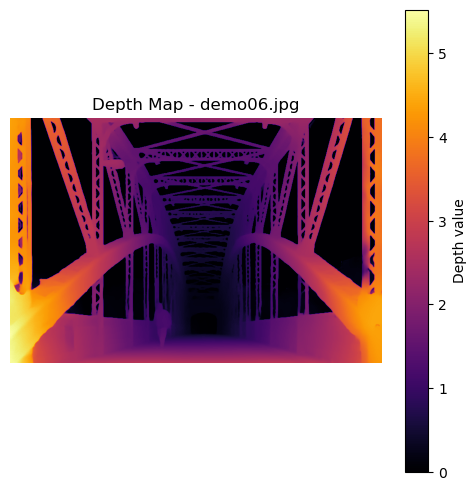

In [7]:
# ============================================================================ 
# IMPORTS
# ============================================================================ 
import torch
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from peft import LoraConfig, get_peft_model, TaskType
from PIL import Image
import matplotlib.pyplot as plt
import os

# ============================================================================ 
# ÉTAPE 1: Charger le modèle pré-entraîné
# ============================================================================ 
def load_pretrained_model(model_name="depth-anything/Depth-Anything-V2-Small-hf", device='cpu'):
    print(f"📥 Chargement du modèle: {model_name}")
    image_processor = AutoImageProcessor.from_pretrained(model_name)
    base_model = AutoModelForDepthEstimation.from_pretrained(model_name).to(device)
    print(f"✅ Modèle chargé avec succès")
    return base_model, image_processor

# ============================================================================ 
# ÉTAPE 2: Configurer LoRA pour fine-tuning
# ============================================================================ 
def configure_lora(rank=8, alpha=16, dropout=0.1):
    print("\n🔧 Configuration de LoRA:")
    print(f"   - Rang (r): {rank}")
    print(f"   - Alpha: {alpha}")
    print(f"   - Dropout: {dropout}")
    
    lora_config = LoraConfig(
        r=rank,
        lora_alpha=alpha,
        target_modules=["query", "value"],  # Cibler les matrices d'attention
        lora_dropout=dropout,
        bias="none",
        task_type=TaskType.FEATURE_EXTRACTION
    )
    return lora_config

def integrate_lora(base_model, lora_config):
    print("\n🔄 Intégration de LoRA dans le modèle...")
    model = get_peft_model(base_model, lora_config)
    print("✅ LoRA intégré (uniquement pour fine-tuning)")
    return model

# ============================================================================ 
# ÉTAPE 3: Inférence sur une seule image
# ============================================================================ 
def infer_image(base_model, image_processor, image_path, device='cpu'):
    """
    ⚠️ Important: Pour l'inférence, utiliser le modèle de base et non LoRA pour éviter l'erreur 'input_ids'.
    """
    print(f"\n🖼️  Inférence sur {os.path.basename(image_path)}")
    image = Image.open(image_path)
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    
    base_model.eval()
    with torch.no_grad():
        outputs = base_model(**inputs)
        predicted_depth = outputs.predicted_depth
    
    depth = predicted_depth.squeeze().cpu().numpy()
    print(f"✅ Inférence réussie | Shape: {depth.shape} | Min: {depth.min():.4f} | Max: {depth.max():.4f}")
    return depth

# ============================================================================ 
# ÉTAPE 4: Affichage
# ============================================================================ 
def display_depth(depth_map, image_name):
    plt.figure(figsize=(6,6))
    plt.imshow(depth_map, cmap='inferno')  # Rouge foncé = proche, jaune = intermédiaire, violet = loin
    plt.axis('off')
    plt.title(f"Depth Map - {image_name}")
    plt.colorbar(label="Depth value")
    plt.show()

# ============================================================================ 
# FONCTION PRINCIPALE
# ============================================================================ 
def main():
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Using device:", DEVICE)
    
    # 1️⃣ Charger le modèle pré-entraîné
    base_model, image_processor = load_pretrained_model(device=DEVICE)
    
    # 2️⃣ Configurer LoRA (pour fine-tuning futur)
    lora_config = configure_lora(rank=8, alpha=16, dropout=0.1)
    lora_model = integrate_lora(base_model, lora_config)
    
    # Afficher un résumé de LoRA
    trainable_params = sum(p.numel() for p in lora_model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in lora_model.parameters())
    print(f"\n📊 Paramètres LoRA: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.4f}%) sont entraînables")
    print("💡 Les paramètres LoRA servent à fine-tuner le modèle sans toucher aux poids pré-entraînés.")
    
    # 3️⃣ Demander l'image à tester
    demo_folder = r"C:\Users\ZEJLI\Desktop\Transformers\Depth-Anything-V2\assets\examples"
    img_number = input("Entrez le numéro de l'image demo (ex: 6 pour demo06.jpg) : ")
    img_name = f"demo{int(img_number):02d}.jpg"
    img_path = os.path.join(demo_folder, img_name)
    if not os.path.exists(img_path):
        print(f"❌ Image non trouvée: {img_path}")
        return
    
    # 4️⃣ Inférence (modèle de base uniquement)
    depth_map = infer_image(base_model, image_processor, img_path, device=DEVICE)
    
    # 5️⃣ Affichage
    display_depth(depth_map, img_name)

if __name__ == "__main__":
    main()


# 💡 LoRA (Low-Rank Adaptation) et Fine-Tuning pour Depth Anything V2

---

## 1️⃣ Introduction

Dans ce projet, nous utilisons **Depth Anything V2**, un modèle pré-entraîné pour la prédiction de profondeur d’images.  
Pour l’adapter à un jeu de données spécifique ou à des besoins particuliers, nous appliquons **LoRA (Low-Rank Adaptation)**, une méthode efficace pour le fine-tuning.

**Objectif :**  
- Adapter le modèle à un nouveau contexte sans réentraîner tous les paramètres  
- Réduire la mémoire et le temps d’entraînement  
- Conserver la performance du modèle pré-entraîné

---

## 2️⃣ LoRA : Qu’est-ce que c’est ?

**LoRA (Low-Rank Adaptation)** est une technique qui introduit de **petites matrices de faible rang** dans les couches du modèle, souvent dans les **couches d’attention** des Transformers.  

### Principe :

Pour une couche avec poids $W_{original}$ :

$$
W_{adapted} = W_{original} + \alpha \cdot A \cdot B
$$

- $A, B$ : matrices de faible rang (rank réduit)  
- $\alpha$ : facteur de scaling pour contrôler l’impact  
- $W_{original}$ : poids pré-entraînés du modèle  

**Pendant le fine-tuning :**  
- Seules les matrices $A$ et $B$ sont entraînables  
- Tous les autres poids sont gelés

**Avantages :**  
- ✅ Réduction drastique du nombre de paramètres à entraîner  
- ✅ Fine-tuning rapide et léger en mémoire  
- ✅ Préservation des poids du modèle original

---

## 3️⃣ Fine-Tuning : Définition et contexte

Le **fine-tuning** consiste à ajuster un modèle pré-entraîné pour un nouveau jeu de données ou une tâche spécifique.  

**Dans le contexte de Depth Anything V2 :**  
- On veut adapter le modèle à des images spécifiques (ex : drones, médical, scènes particulières)  
- Avec LoRA, on entraîne uniquement les matrices de faible rang, donc :
  - Optimiseur : touche uniquement les matrices LoRA  
  - Les poids du modèle original restent **gelés** ❄️  
- Résultat : adaptation rapide et peu coûteuse

**Paramètres typiques pour LoRA :**  
- Rang $r = 8$  
- Facteur de scaling $\alpha = 16$  
- Dropout = 0.1  

---

## 4️⃣ Intégration de LoRA dans Depth Anything V2

**Architecture cible :**  
- Couches d’attention : `query` et `value` du Vision Transformer  
- Poids du modèle pré-entraîné : gelés (~99%)  
- Paramètres LoRA : entraînables (~1%)

### Schéma conceptuel LoRA pour Depth Anything V2

Modèle pré-entraîné **Depth Anything V2**  
⬇️  
**Poids gelés ❄️**  
⬇️  
**Couches attention (query, value)**  
  ⬇️  
  **Matrices LoRA (A et B) → entraînables ✅**  
⬇️  
**Inférence / Fine-Tuning**

---

**Explications :**  
- Les **poids du modèle original** restent gelés pour préserver les connaissances pré-entraînées.  
- Les **matrices LoRA** sont les seules parties entraînables, permettant un fine-tuning rapide et économique.  
- L’**inférence** peut utiliser soit le modèle de base seul, soit le modèle adapté via LoRA.




**Résumé :**  
- ✅ Fine-tuning rapide et économique  
- ✅ Préservation de la performance du modèle original  
- ✅ Possibilité de spécialiser le modèle sur un jeu de données particulier

---

## 5️⃣ Pipeline général

1. **Charger le modèle pré-entraîné** : Depth Anything V2  
2. **Configurer LoRA** : matrices $A$ et $B$, rank, alpha, dropout  
3. **Intégrer LoRA dans le modèle**  
4. **Geler tous les autres paramètres**  
5. **Préparer l’optimiseur pour le fine-tuning** (seuls les paramètres LoRA seront mis à jour)  
6. **Inférer ou fine-tuner sur de nouvelles images**

---

## 6️⃣ Inférence et visualisation

Lors de l’inférence avec LoRA :  
- Si le modèle a été fine-tuné, les matrices LoRA influencent la prédiction  
- Sinon, le modèle fonctionne comme le modèle original  

**Exemple de visualisation :**  
- Carte de profondeur en couleur (`cmap='inferno'`)  
- Rouge foncé : objets proches  
- Bleu/vert : objets éloignés

**Interprétation :**  
- Les variations de couleur reflètent la profondeur relative des objets dans l’image  
- LoRA permet au modèle de s’adapter à de nouvelles images sans toucher aux poids originaux

---

## 7️⃣ Résumé des concepts

| Composant        | Rôle                                | Entraînable ? |
|-----------------|-------------------------------------|---------------|
| Poids du modèle  | Pré-entraînés                       | ❄️ Non       |
| Matrices LoRA    | Adaptation de faible rang           | ✅ Oui       |
| Fine-tuning      | Adaptation à un nouveau domaine     | ✅ Oui       |

### Points clés :

1. LoRA réduit le coût et le temps du fine-tuning  
2. Les poids originaux restent intacts, assurant stabilité et performance  
3. Adaptation possible sur un **jeu d’images spécifique**  
4. Fine-tuning léger et réversible  
5. Inférence normale possible même sans fine-tuning

---

### 📌 Conclusion

- LoRA est une méthode efficace pour adapter un modèle de **deep learning volumineux** avec très peu de paramètres supplémentaires  
- Idéal pour **Depth Anything V2**, car permet de spécialiser la prédiction de profondeur sans réentraîner tout le modèle  
- Combine **rapidité**, **efficacité mémoire**, et **préservation des performances**
